# Housing data analysis 

## Objectives

## Data download and structure

In [1]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# downloading data
import os
import tarfile
import urllib

# set up paths
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
import pandas as pd

# set up download data function
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path,  exist_ok=True)
    tgz_path = os.path.join(housing_path,  "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# loading data function
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
# try to load data, if data was not downloaded, go to exception
try:
    # load data
    housing = load_housing_data()
except:
    # download data
    fetch_housing_data()
    # load data
    housing = load_housing_data()    

In [5]:
# data structure
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Some insights we already can get from the structure:
1. There are 20,640 instances.
2. 207 regions lack `total_bedrooms` data.
3. `ocean_proximity` probably is categoric.

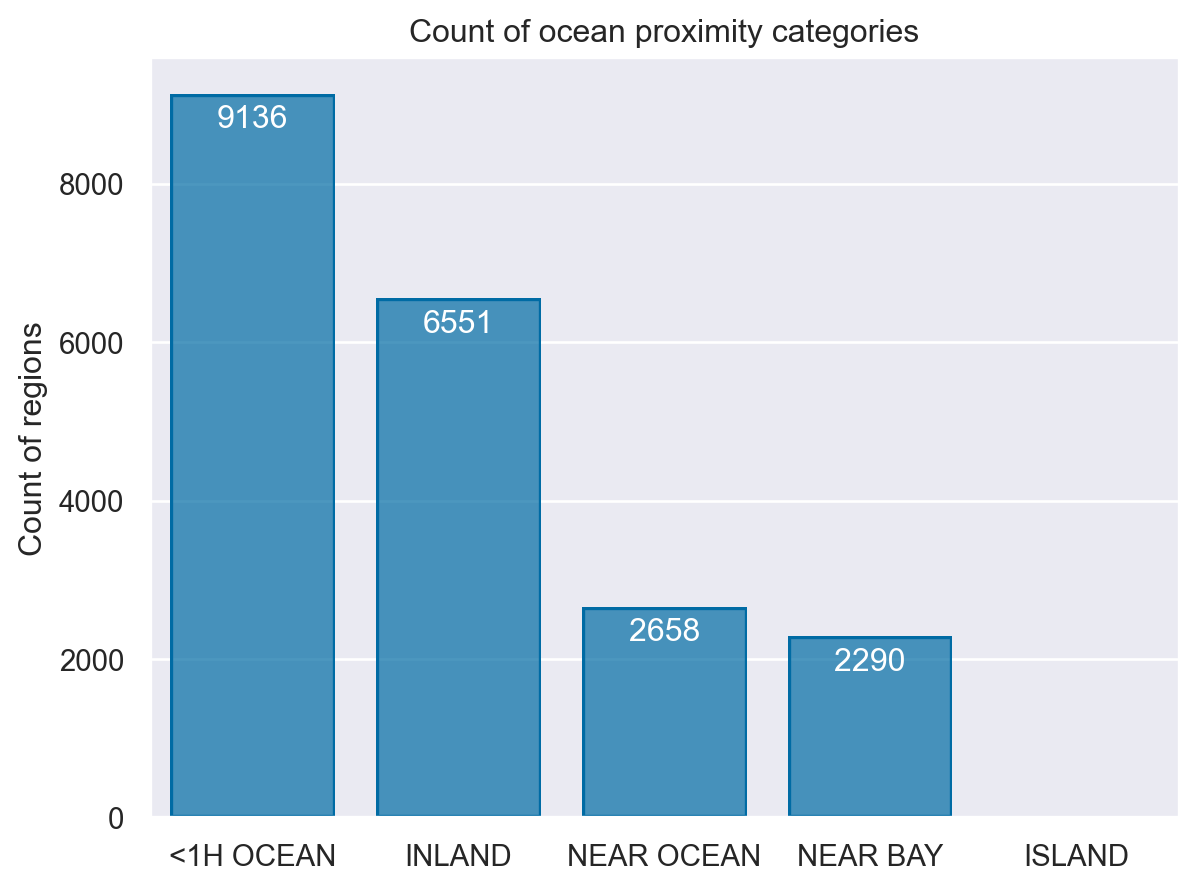

In [6]:
# identify categories and count in ocean_proximity
import seaborn.objects as so
from matplotlib import style
import warnings

# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

vc = housing["ocean_proximity"].value_counts()
(
    so.Plot(x=vc.index, y=vc, text=vc)
    .add(so.Bar())
    .add(so.Text(color="w", valign="top"))
).\
    label(title="Count of ocean proximity categories"
          , x="" 
          , y="Count of regions").\
          theme({**style.library["tableau-colorblind10"]})

There are more regions `< 1H OCEAN` than `INLAND`. This can be included for later analysis.

In [7]:
# summary of numeric data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


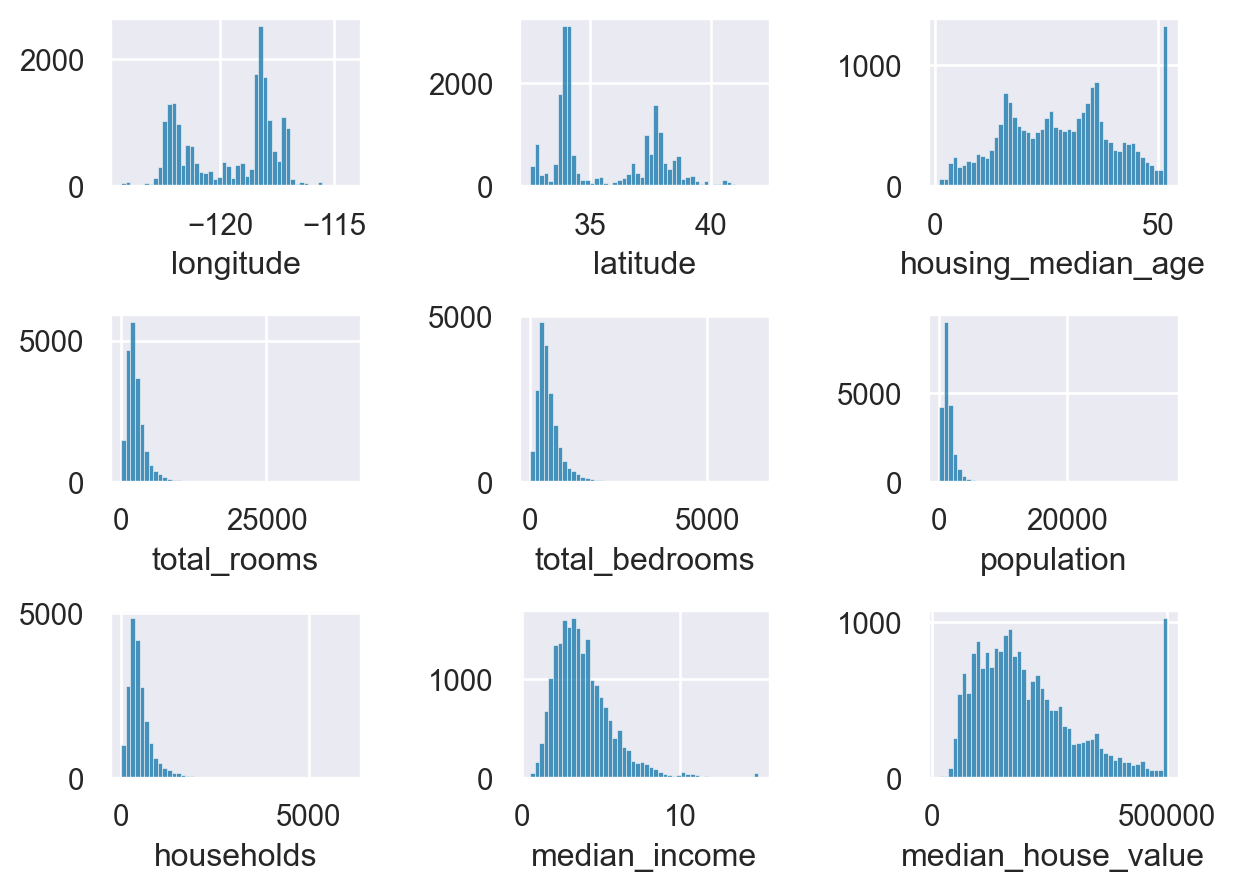

In [8]:
(
    so.Plot(housing)
    .pair(x=list(housing.select_dtypes("float64").columns), wrap=3)
    .share(y=False)
    .add(so.Bars(), so.Hist(bins=50, common_bins=False))
    .theme({**style.library["tableau-colorblind10"]})
)

The main takeouts of the charts:

1. the `median_income` is not in USD (min: 0.49; max: 15)
2. the high counts for the last values of `housing_median_age` and `median_house_value` indicates that it was proposed a threshold for both features.
3. the features have different scales and they do not seem to have a Gauss distribution.

## Test set

To avoid confusion (the *data snooping bias*), we're going to split the data into the `train_set` and `test_set` before the complete EDA.

In [9]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)

However, the model would benefit from stratification of the `train_set` by  the `median_income`. Therefore, we will create a new feature with income categories.

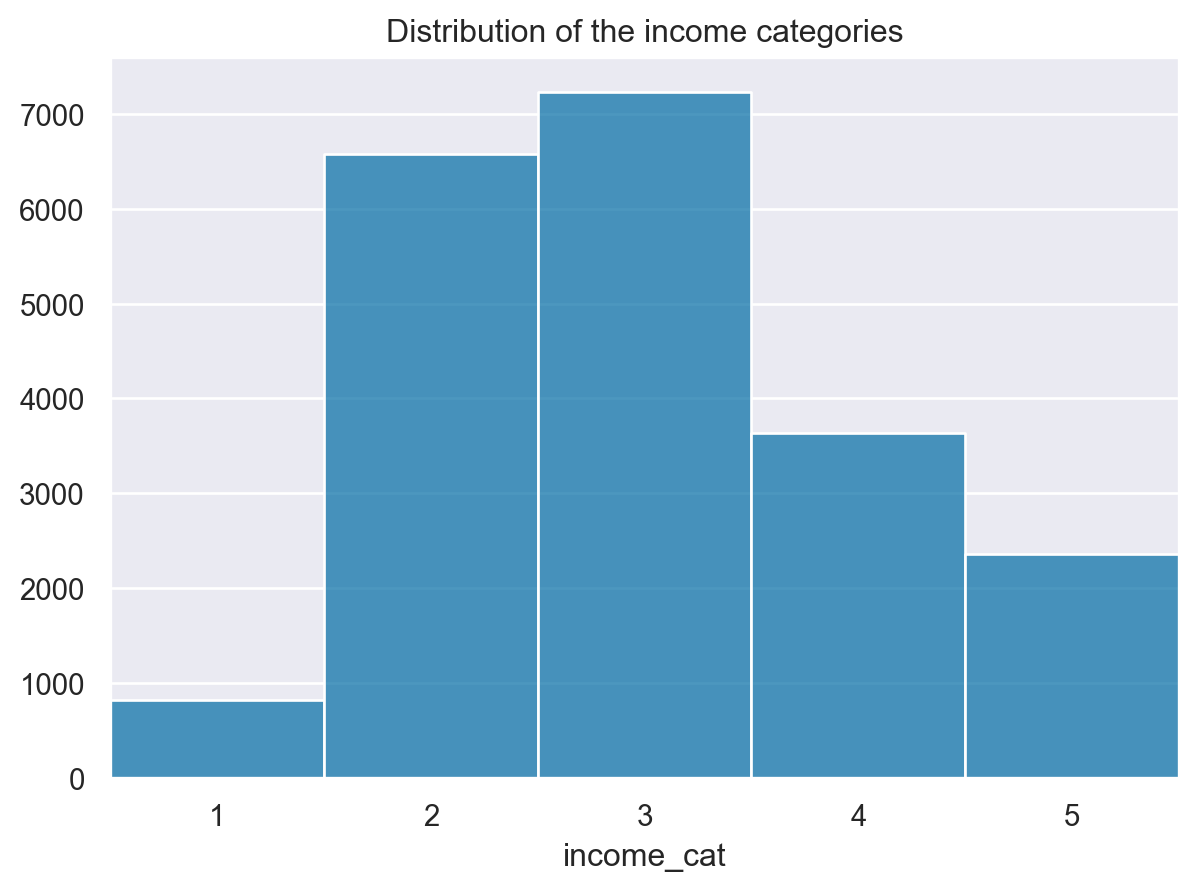

In [10]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3., 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

(
    so.Plot(x=housing["income_cat"])
    .add(so.Bars(), so.Hist())
    .label(title="Distribution of the income categories")
    .theme({**style.library["tableau-colorblind10"]})
)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# set up the function
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
# apply the split
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [12]:
# checking if the stratification is the same of the original proportions
strat_train_set["income_cat"].value_counts(normalize=True).round(2) \
    == housing["income_cat"].value_counts(normalize=True).round(2)

income_cat
3    True
2    True
4    True
5    True
1    True
Name: proportion, dtype: bool

In [13]:
# removing income_cat
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Exploratory Data Analysis

Now that we've created the `train_set`, we can explore the data.

In [14]:
# create a copy to avoid messing with the train set
housing = strat_train_set.copy()

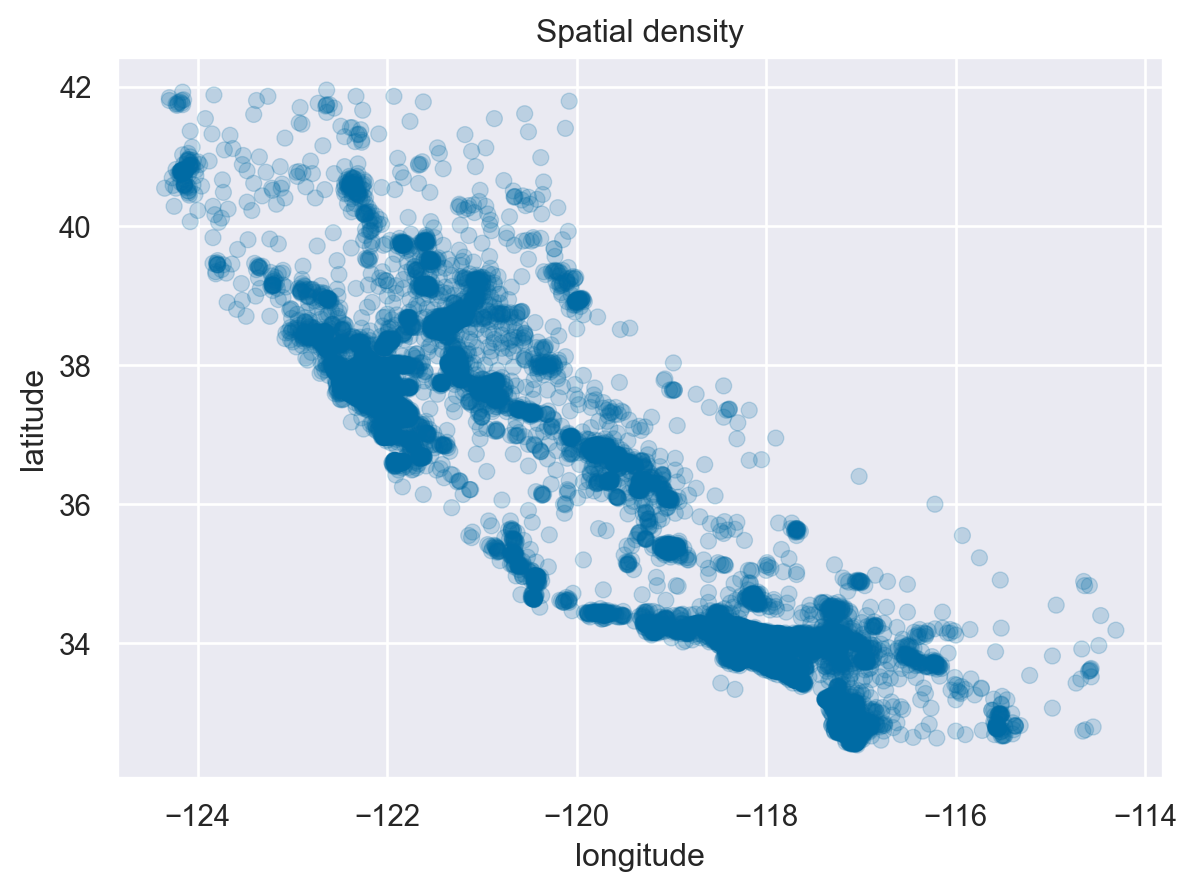

In [15]:
(
    so.Plot(housing, "longitude", "latitude")
    .add(so.Dot(alpha=.2))    
    .label(title="Spatial density")
    .theme({**style.library["tableau-colorblind10"]})
)

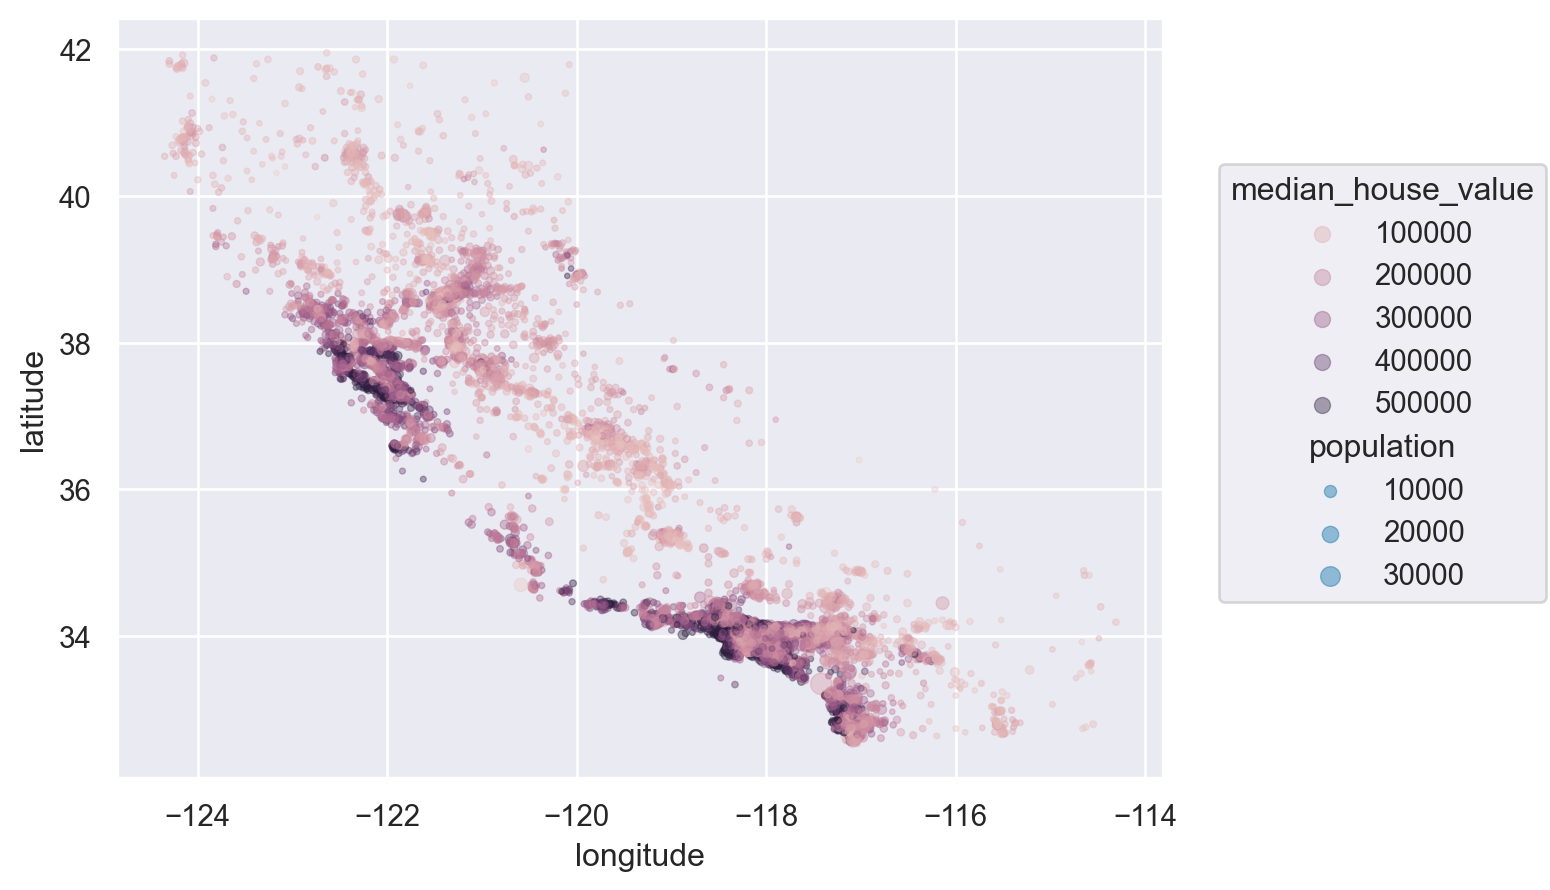

In [16]:
# including new parameters
(
    so.Plot(housing, "longitude", "latitude", 
            color="median_house_value", pointsize="population")
    .add(so.Dot(alpha=.4))
    .theme({**style.library["tableau-colorblind10"]})
)

It's remarkable that location and density have a great influence on the `median_house_value`.

### Correlation

In [17]:
corr_matrix = housing.select_dtypes("float64").corr()["median_house_value"].sort_values(ascending=False)
pd.DataFrame(
    {
        "variable": list(corr_matrix.index),
        "correlation": list(corr_matrix)
}).style \
.format(precision=3)

,variable,correlation
0,median_house_value,1.000
1,median_income,0.687
2,total_rooms,0.135
3,housing_median_age,0.114
4,households,0.065
5,total_bedrooms,0.048
6,population,-0.027
7,longitude,-0.047
8,latitude,-0.143


As expected, the feature with higher correlation with `median_house_value` is `median_income`. Also, the number of rooms and the housing age have a positive correlation with the target. 

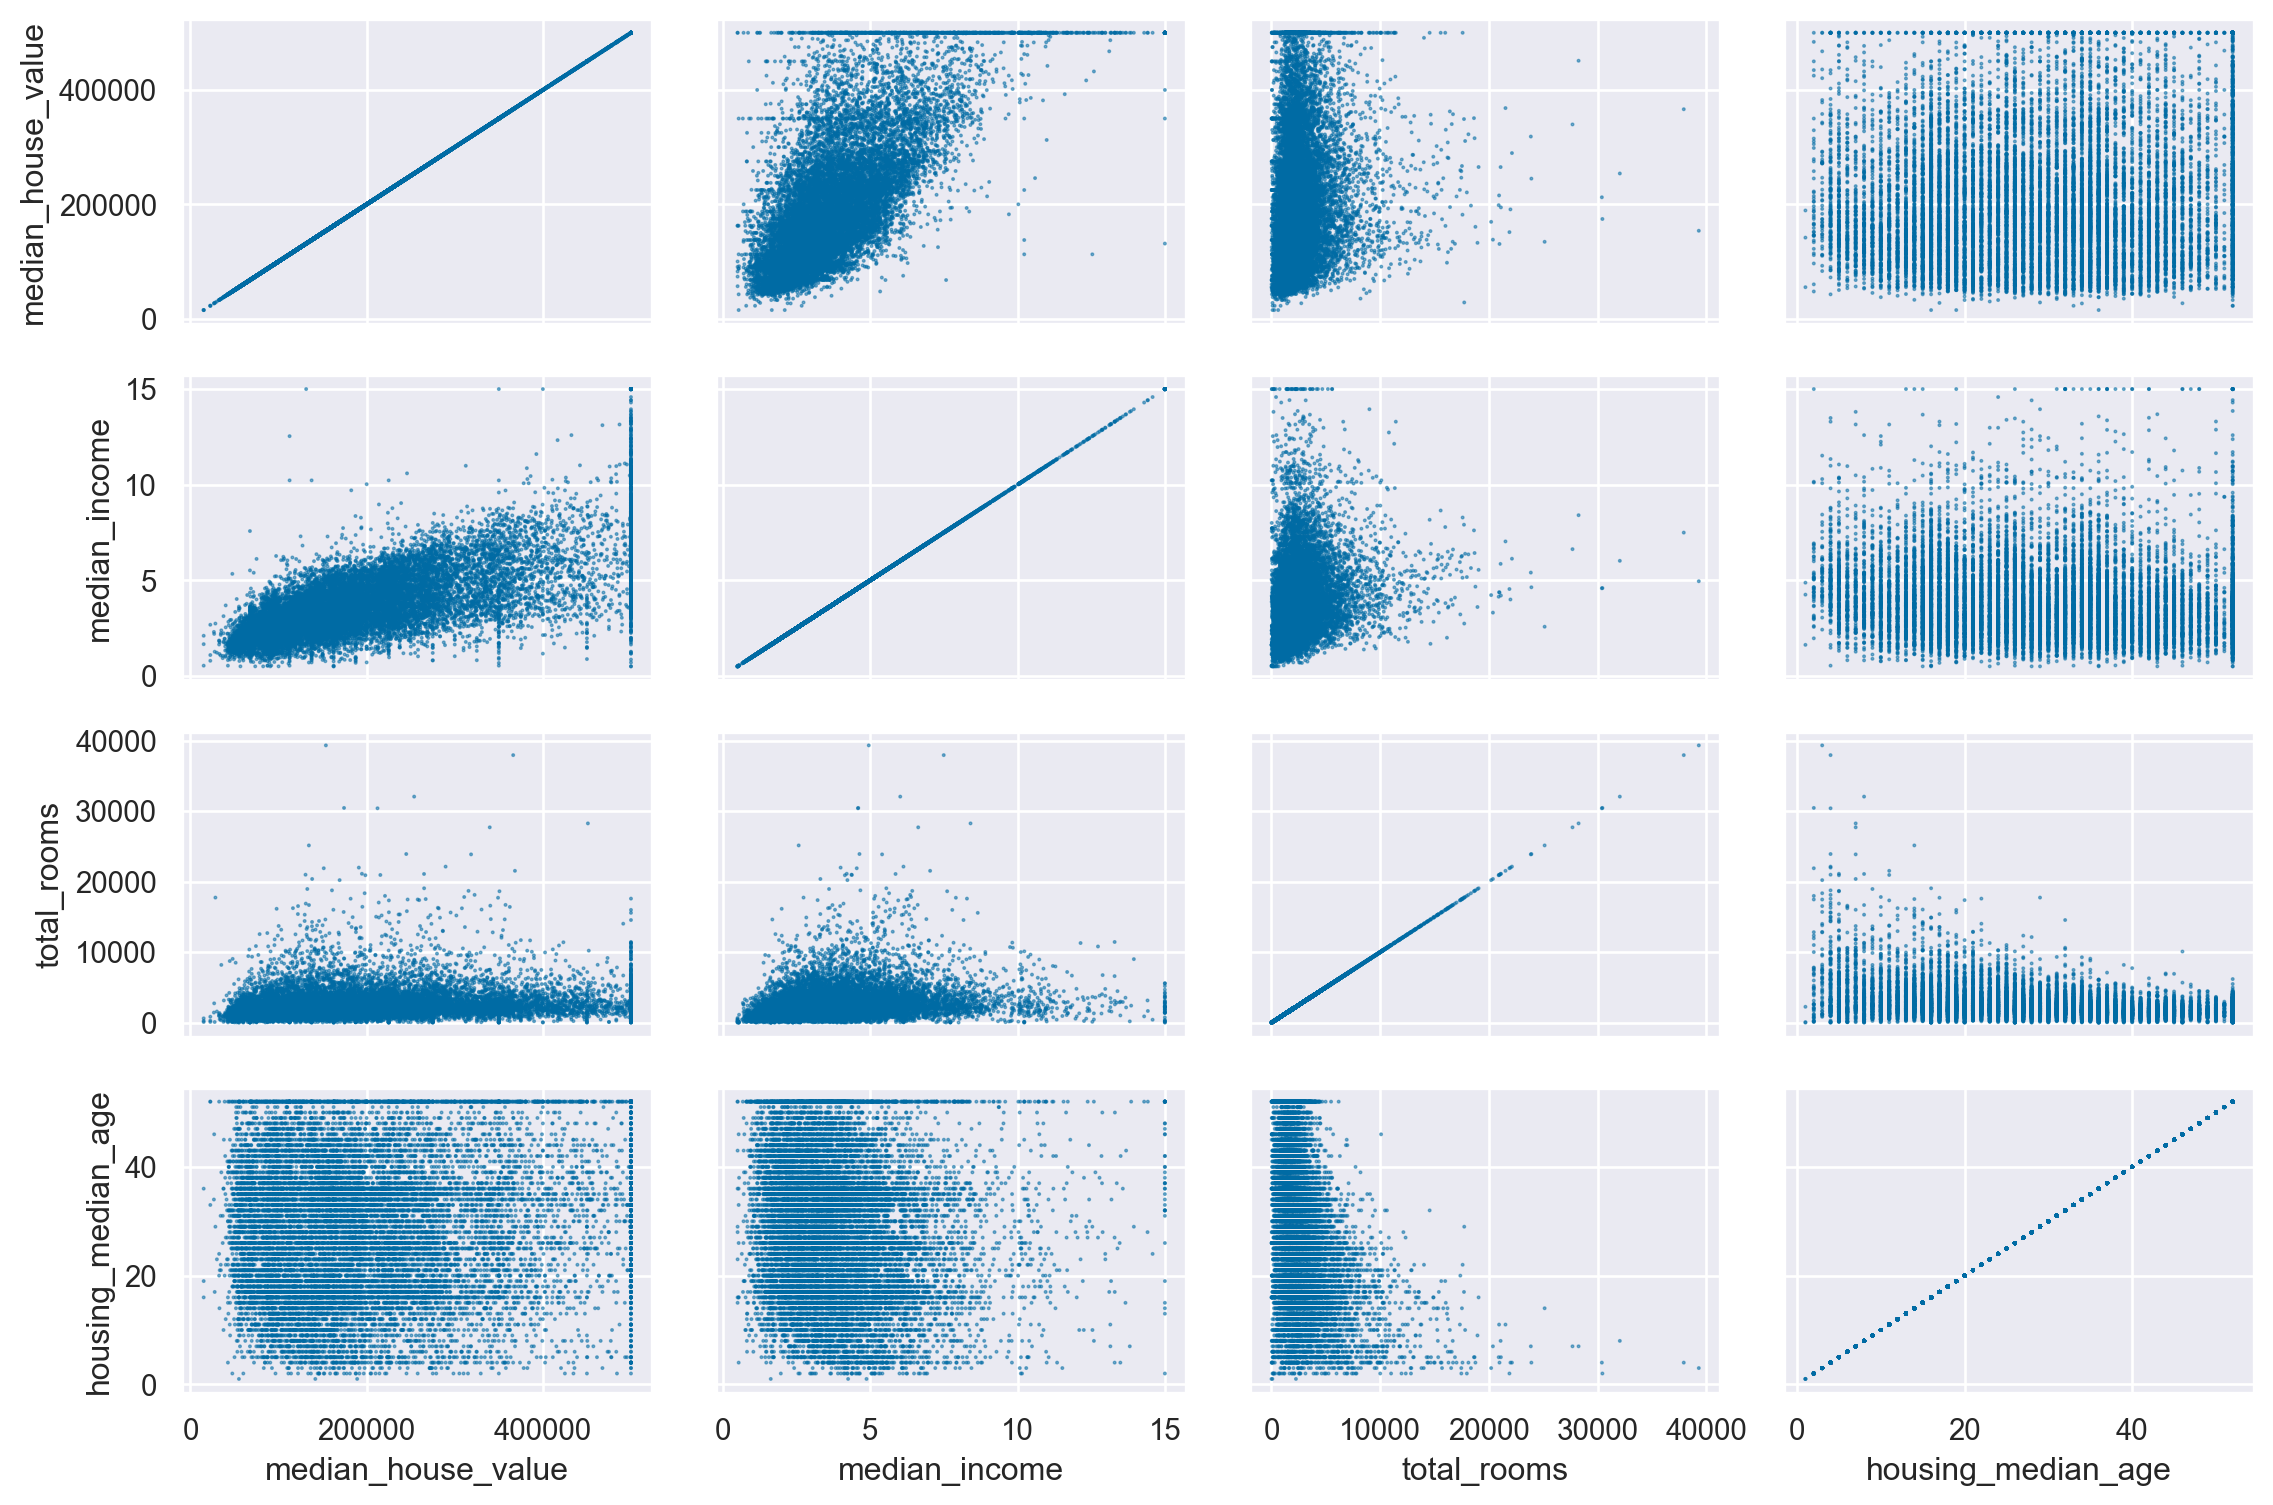

In [18]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
(
    so.Plot(housing)
    .pair(x=attributes, y=attributes)
    .add(so.Dot(pointsize=1, alpha=.5))
    .theme({**style.library["tableau-colorblind10"]})
    .layout(size=(12,8))
)

One thing to notice is the relative value of the income, housing age and the house value. Meanwhile we have the absolute values for: rooms, households, bedrooms and population. It will be probably for the best if we worked with relative values also for these features.

In [19]:
# combining some features
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [20]:
# checking the correlation
corr_matrix = housing.select_dtypes("float64").corr()["median_house_value"].sort_values(ascending=False)
pd.DataFrame(
    {
        "variable": list(corr_matrix.index),
        "correlation": list(corr_matrix)
}).style \
.format(precision=3)

,variable,correlation
0,median_house_value,1.000
1,median_income,0.687
2,rooms_per_household,0.146
3,total_rooms,0.135
4,housing_median_age,0.114
5,households,0.065
6,total_bedrooms,0.048
7,population_per_household,-0.022
8,population,-0.027
9,longitude,-0.047


The biggest change here is the increase of the correlation including bedrooms for the relative number. Also, there is a slight increase for the relative number of rooms per household.

## Data preparation for ML

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Cleaning NAs

In [22]:
#  cleaning data - NAs
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# we can only apply it in numeric variables
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num) # stores the median in .statistics_
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [23]:
# substitute NAs to the variable median
housing_tr = pd.DataFrame(
    imputer.transform(housing_num),
    columns=housing_num.columns,
    index=housing_num.index
)

### Categoric data

We already know that there is a categoric feature in the data base. There is two possibilities to deal with it:

1. Use the `OrdinalEncoder`, which would be beneficial if we had the hierarchy of the categories;
2. Use the `OneHotEncoder`, which will create the *dummies* for each category.

In [24]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### Customizing the transformers

We created some features that will contribute to the ML. For the creation of the pipeline, considering the addition of new data, it is important to create a transformer.

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

# cols position
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attrs = attr_adder.transform(housing.values)

### Scaling

There are two options to scale the data:

*Min-max*, with `MinMaxScaler`: 
$ z_i = \frac{x_i - x_{min}}{x_{max}}$

*Standardization*, with `StandardScaler`:
$ z_i = \frac{x_i - \bar{x}}{s^2}$

### Pipelines

It is possible to automatize all the data preparation by using the Pipelines.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numeric pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

It is possible to create a pipeline to preprocess the whole dataframe. 

In [27]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

In [28]:
# fit and transform the pipeline
housing_prepared = full_pipeline.fit_transform(housing)

## Training the model

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [39]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

### Evaluation

First, for the linear regression

In [31]:
from sklearn.metrics import mean_squared_error

lin_pred = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, lin_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

Now, for the Decision Tree.

In [33]:
tree_pred = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, tree_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The result is a little bit weird and probably indicates an overfit. We can try to use the cross validation to avoid it. But before applying it, let's check the `Random Forest`'s error.

In [40]:
forest_pred = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18701.240305016025

### Cross Validation

In [34]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [36]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deciation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [72485.42255748 70702.80084279 69242.91351819 71160.09589662
 69405.28435111 77512.34884868 70478.64606036 73366.16890443
 69072.51970032 70730.2062693 ]
Mean: 71415.64069492681
Standard deciation: 2414.3852001348478


In [37]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deciation: 2880.3282098180653


In [41]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [51651.47773041 48677.17652766 46827.91571434 52171.97543978
 47250.84912133 52008.16186035 52566.14832347 50174.24635044
 48439.48160725 53882.98492846]
Mean: 50365.04176034978
Standard deciation: 2316.0979042321974
